In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

2022-12-21 00:08:35.167845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_all = pd.read_csv('BeloitWWTP.csv')
data_all.info()
data_all

df = data_all[['Influent_Flow','Influent_CBOD',
               'Influent_TSS','Influent_TP','Influent_NH3','Aeration_MLDO_3',
              'Aeration_MLTSS_3','Aeration_AirFlow_3','Effluent_Flow(MGD)',
               'Effluent_CBOD','Effluent_TSS','Effluent_NH3','Effluent_TP']]
df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           990 non-null    object 
 1   Influent_Flow                  990 non-null    float64
 2   Influent_CBOD                  990 non-null    float64
 3   Influent_TSS                   990 non-null    float64
 4   Influent_TP                    990 non-null    float64
 5   Influent_NH3                   990 non-null    float64
 6   Aeration_MLDO_3                990 non-null    float64
 7   Aeration_MLDO_4                990 non-null    float64
 8   Aeration_MLDO_5                990 non-null    float64
 9   Aeration_MLTSS_3               989 non-null    float64
 10  Aeration_MLTSS_4               989 non-null    float64
 11  Aeration_MLTSS_5               989 non-null    float64
 12  Aeration_MLTSS_Avg             989 non-null    flo

In [3]:
data = df[['Effluent_TP','Effluent_TSS','Effluent_CBOD','Effluent_NH3','Influent_CBOD','Influent_TP','Influent_NH3',
           'Influent_Flow']]
data

,Effluent_TP,Effluent_TSS,Effluent_CBOD,Effluent_NH3,Influent_CBOD,Influent_TP,Influent_NH3,Influent_Flow
0,0.22,2.50,NaN,0.08,548.95,5.2,16.20,6.23
1,0.19,3.80,NaN,0.08,548.95,5.0,25.51,6.05
2,0.23,4.30,NaN,0.08,548.95,1.0,19.70,5.82
3,0.27,4.50,4.2,0.08,450.00,6.5,25.51,5.57
4,0.37,4.50,5.2,0.10,446.00,7.2,22.90,5.47
...,...,...,...,...,...,...,...,...
985,0.21,3.66,2.4,0.11,573.75,11.8,31.40,4.29
986,0.21,2.00,2.4,0.11,573.75,11.8,31.40,4.04
987,0.21,2.60,2.4,0.11,573.75,11.8,31.40,4.17
988,0.21,2.20,2.4,0.11,573.75,11.8,31.40,4.10


In [4]:
dataset = data
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

print(reframed.head())

values = reframed.values
n_train_hours = int(len(values)*0.80)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=500, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
4   0.044925   0.124224   0.381935   0.121622   0.418216   0.370130   
5   0.061564   0.124224   0.510968   0.148649   0.414498   0.415584   
6   0.028286   0.131531   0.510968   0.148649   0.510177   0.422078   
7   0.044925   0.131531   0.510968   0.148649   0.510177   0.253247   
8   0.061564   0.153453   0.214194   0.162162   0.446097   0.370130   

   var7(t-1)  var8(t-1)   var1(t)  
4   0.655784   0.331488  0.061564  
5   0.588689   0.325338  0.028286  
6   0.655784   0.324723  0.044925  
7   0.655784   0.297048  0.061564  
8   0.686375   0.279828  0.061564  
(788, 1, 8) (788,) (198, 1, 8) (198,)


2022-12-21 00:08:43.333136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
79/79 - 2s - loss: 0.0409 - val_loss: 0.0689 - 2s/epoch - 30ms/step
Epoch 2/500
79/79 - 0s - loss: 0.0342 - val_loss: 0.0651 - 158ms/epoch - 2ms/step
Epoch 3/500
79/79 - 0s - loss: 0.0316 - val_loss: 0.0638 - 146ms/epoch - 2ms/step
Epoch 4/500
79/79 - 0s - loss: 0.0303 - val_loss: 0.0615 - 147ms/epoch - 2ms/step
Epoch 5/500
79/79 - 0s - loss: 0.0292 - val_loss: 0.0597 - 151ms/epoch - 2ms/step
Epoch 6/500
79/79 - 0s - loss: 0.0280 - val_loss: 0.0568 - 150ms/epoch - 2ms/step
Epoch 7/500
79/79 - 0s - loss: 0.0273 - val_loss: 0.0563 - 141ms/epoch - 2ms/step
Epoch 8/500
79/79 - 0s - loss: 0.0270 - val_loss: 0.0546 - 172ms/epoch - 2ms/step
Epoch 9/500
79/79 - 0s - loss: 0.0265 - val_loss: 0.0530 - 206ms/epoch - 3ms/step
Epoch 10/500
79/79 - 0s - loss: 0.0260 - val_loss: 0.0516 - 200ms/epoch - 3ms/step
Epoch 11/500
79/79 - 0s - loss: 0.0250 - val_loss: 0.0493 - 188ms/epoch - 2ms/step
Epoch 12/500
79/79 - 0s - loss: 0.0251 - val_loss: 0.0483 - 178ms/epoch - 2ms/step
Epoch 13/500
79

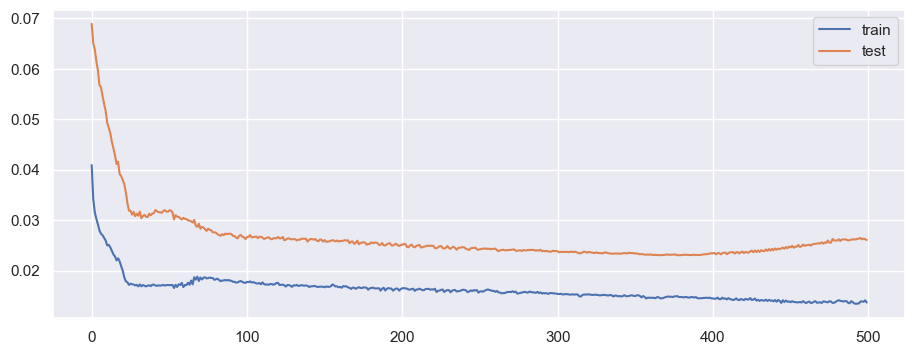

In [5]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [6]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


7/7 [==============================] - 0s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

#RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(inv_y,inv_yhat)
print ('Test MAE: %.3f' % mae)

#r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
r2 = r2_score(inv_y,inv_yhat)
print ('Test r2 score: %.3f' % r2)

Test RMSE: 0.397
Test MAE: 0.157
Test r2 score: 0.848


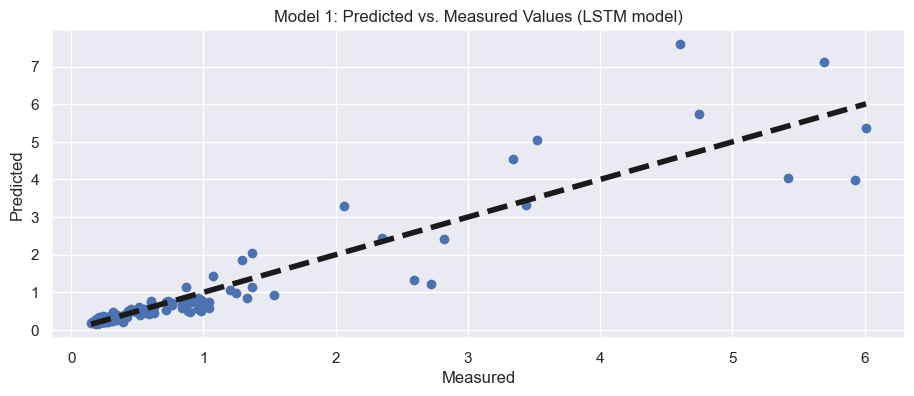

In [8]:
fig, ax = plt.subplots()
ax.scatter(inv_y, inv_yhat)
ax.plot([inv_y.min(), inv_y.max()], [inv_y.min(), inv_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
pyplot.title('Model 1: Predicted vs. Measured Values (LSTM model)')
plt.show()

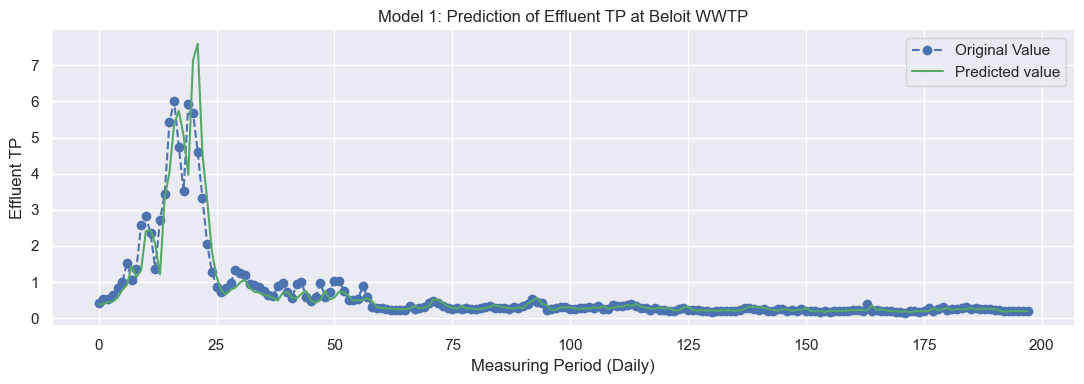

In [9]:
pyplot.title('Model 1: Prediction of Effluent TP at Beloit WWTP')
pyplot.plot(figsize=(10,9))
pyplot.ylabel('Effluent TP')
pyplot.xlabel('Measuring Period (Daily)')
pyplot.plot(inv_y,linestyle='--', marker='o', color='b', label='Original Value'  )
pyplot.plot(inv_yhat, linestyle='solid',color='g', label='Predicted value')
pyplot.legend(loc='upper right')
sns.despine(top=True)
pyplot.tight_layout()
pyplot.show()